# Signal Processing Demo
We will use some signal processing techniques to reduce the training data for our deep learning model

In [ ]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal import spectrogram

## Loading Audio and some pre-processing
- The audio must be in .wav format
- It will be converted to single channel (mono) and normalized

In [28]:
WAV_PATH = "f1_v10.wav"
sr, x = wavfile.read(WAV_PATH)

# Mono + float normalize to [-1, 1]
if x.ndim == 2:
    x = x.mean(axis=1)
if np.issubdtype(x.dtype, np.integer):
    x = x / np.iinfo(x.dtype).max
x = x.astype(np.float32, copy=False)

## Inspecting the Spectrum
Ideally we would see distinct peaks in the spectrum, but since the engine doesn't run at a constant speed, we can't find noticable peaks.

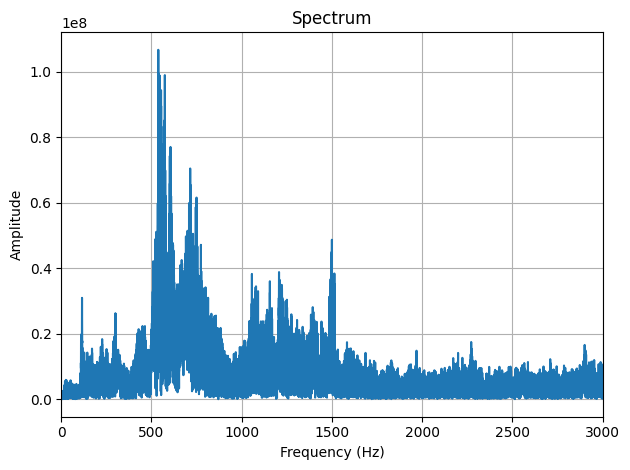

In [29]:
N = len(x)
X = np.fft.rfft(x)
f = np.fft.rfftfreq(N, d=1/sr)

plt.plot(f, np.abs(X))
plt.xlim(0, 3000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Spectrum")
plt.grid(True)
plt.tight_layout()
plt.show()

## Creating the Spectrogram
### Spectrogram v. Simple Spectrum
Spectrogram shows us how the spectrum varies with time, it does so by finding the spectrum for a small amout of time (short time Fourier transform). Whereas traditional spectrum uses the whole record.

Problems:
- Fundamental frequency changes with time
- We don't know where exactly the fundamental frequency is 
    - Ideally we would use the engine speed to determine the fundamental, but we do not have that information in audio

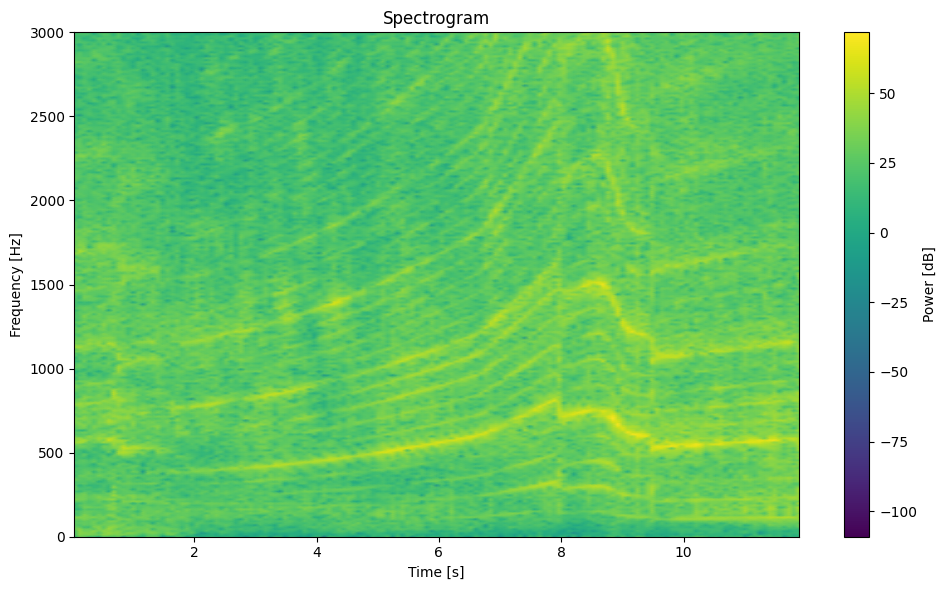

In [30]:
nperseg = 4096
noverlap = 256
f, t, Sxx = spectrogram(x, fs=sr, nperseg=nperseg, noverlap=noverlap)

# Sxx is power (>=0). Convert to dB for visualization:
eps = 1e-12
S_db = 10 * np.log10(Sxx + eps)

# ---- Plot ----
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, S_db, shading="gouraud")
# plt.pcolormesh(t, f, Sxx, shading="gouraud")  
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(0,3000)
plt.title("Spectrogram")
cbar = plt.colorbar()
cbar.set_label("Power [dB]")
plt.tight_layout()
plt.show()


## Finding the Fundamental Frequency
The fundamental frequency is usually the highest amplitude frequency in a given time, but not always.
The solution is to find the top local maxima and pick the maxima that form a smooth line.

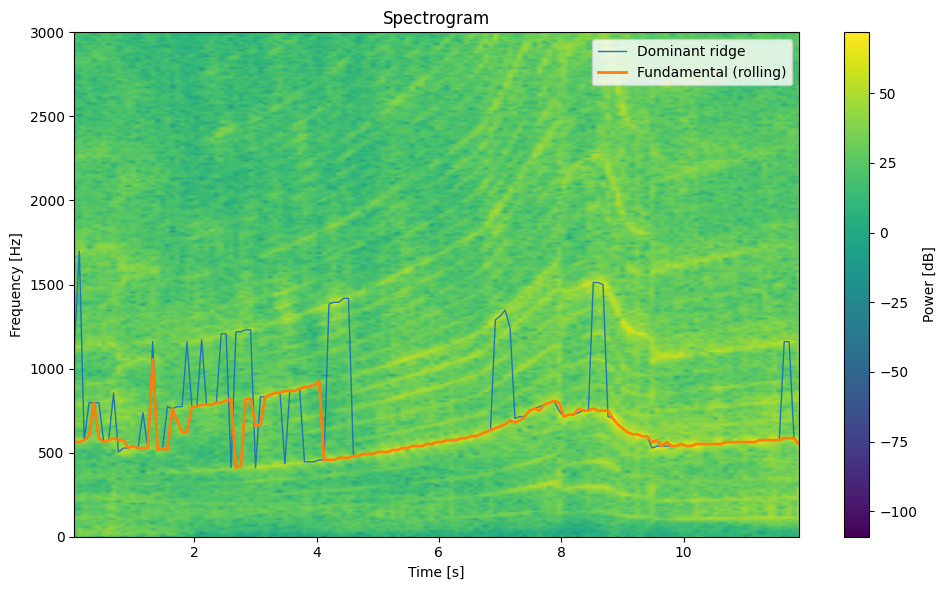

In [31]:
from signal_processing import topk_local_maxima_per_col, fundamental_per_col

# ---- Peak picking (top-K per time slice) ----
K = 3
top_idx, top_vals = topk_local_maxima_per_col(Sxx, K)

# ---- Fundamental from rolling-average of peaks ----
fund_idx = fundamental_per_col(top_idx)
fund_freq = np.where(fund_idx >= 0, f[fund_idx.clip(min=0)], np.nan)

# Frequencies of those peaks (K x T), NaN where no peak
mask = top_idx >= 0
# Clip avoids negative index in the gather; masked later anyway.
freq_at_peaks = np.where(mask, f[top_idx.clip(min=0)], np.nan)

# Dominant ridge (highest peak per column if it exists)
dominant_freq = np.where(mask[0], f[top_idx[0].clip(min=0)], np.nan)


# ---- Plot Spectrogram----
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, S_db, shading="gouraud")

# Overlay dominant ridge as a thin line (where available)
# Build a mask to avoid connecting NaN gaps
valid = ~np.isnan(dominant_freq)
if np.any(valid):
    plt.plot(t[valid], dominant_freq[valid], linewidth=1.0, label="Dominant ridge")

# Overlay fundamental (as a line, skipping gaps)
valid_f = ~np.isnan(fund_freq)
if np.any(valid_f):
    plt.plot(t[valid_f], fund_freq[valid_f], linewidth=2.0, label="Fundamental (rolling)")

plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(0,3000)
plt.title("Spectrogram")
cbar = plt.colorbar()
cbar.set_label("Power [dB]")
plt.legend()
plt.tight_layout()
plt.show()

## Transforming the Spectrogram into Order Domain
Transforming the y-axis from frequency to multiples of the fundamental frequency. This removes the unwanted effect of the engine reving up or down overtime.

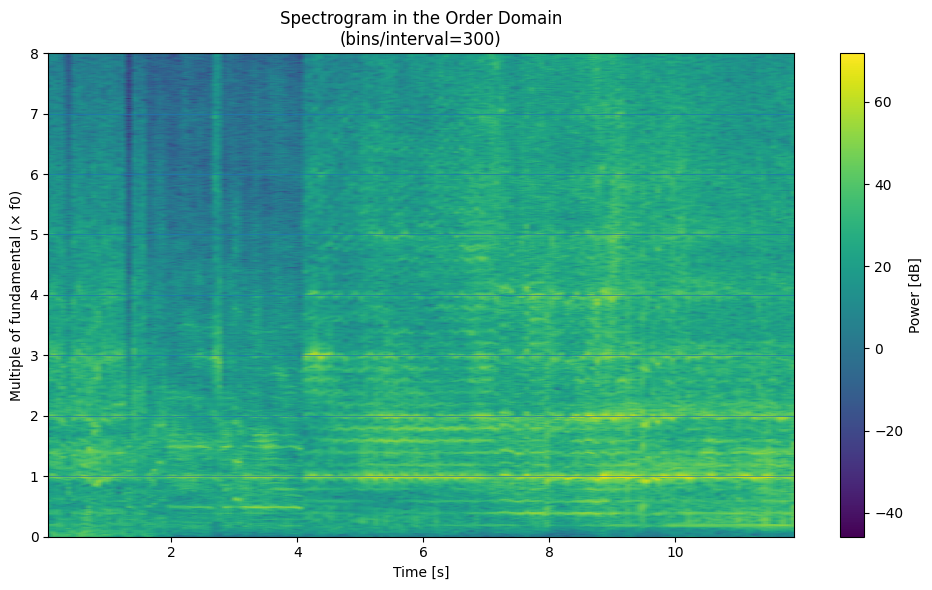

In [ ]:
from signal_processing import transform_spectrogram_to_orders

num_orders     = 8 
bins_per_interval = 60     # subdivisions between integer multiples
S_mult = transform_spectrogram_to_orders(Sxx, fund_idx,
                                            num_orders=num_orders,
                                            bins_per_interval=bins_per_interval)

# Convert to dB for visualization (Sxx is power)
eps = 1e-12
S_mult_db = 10 * np.log10(S_mult + eps)

# y-axis in “× f0”
y_mult = np.arange(S_mult.shape[0]) / float(bins_per_interval)

# ---- Plot transformed spectrogram ----
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, y_mult, S_mult_db, shading="gouraud")
plt.xlabel("Time [s]")
plt.ylabel("Multiple of fundamental (× f0)")
plt.ylim(0, num_orders)
plt.title(f"Spectrogram in the Order Domain\n(bins/interval={bins_per_interval})")

# optional: draw horizontal lines at integer multiples
for m in range(1, num_orders + 1):
    plt.axhline(m, linewidth=0.5)

cbar = plt.colorbar()
cbar.set_label("Power [dB]")
plt.tight_layout()
plt.show()

## Time Averaging in the Order Domain
The order domain spectrogram looks largely constant through time. We can reduce the amount of data by averaging the amplitude/power information through time, producing a time-independent order domained spectrum.

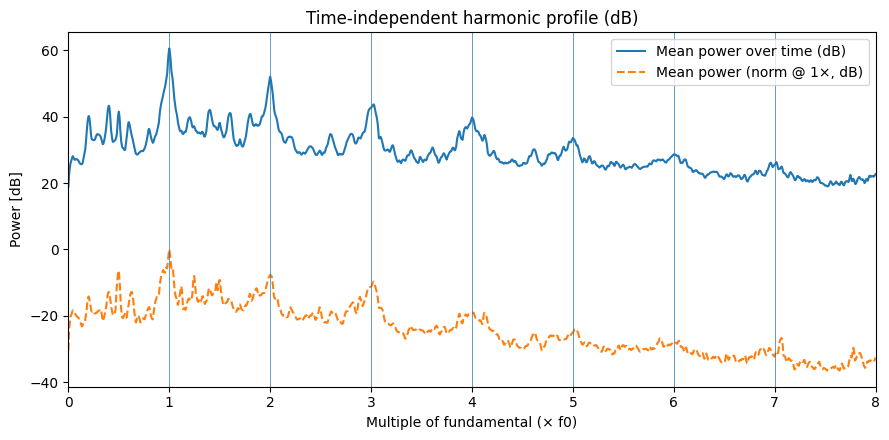

In [35]:
from signal_processing import time_avg_harmonic_profile

x_mult, P_mean, P_rel_mean = time_avg_harmonic_profile(
    Sxx, fund_idx,
    num_orders=num_orders,
    bins_per_interval=bins_per_interval,
    normalize_at_1x=True   # also returns the per-frame-1× normalized average
)

eps = 1e-12
P_mean_db = 10.0 * np.log10(P_mean + eps)
P_rel_mean_db = None if P_rel_mean is None else 10.0 * np.log10(P_rel_mean + eps)

# Plot
plt.figure(figsize=(9, 4.5))
plt.plot(x_mult, P_mean_db, label="Mean power over time (dB)")
if P_rel_mean_db is not None:
    plt.plot(x_mult, P_rel_mean_db, linestyle="--", label="Mean power (norm @ 1×, dB)")

for m in range(1, num_orders + 1):
    plt.axvline(m, linewidth=0.5)

plt.xlim(0, num_orders)
plt.xlabel("Multiple of fundamental (× f0)")
plt.ylabel("Power [dB]")
plt.title("Time-independent harmonic profile (dB)")
plt.legend()
plt.tight_layout()
plt.show()

The harmonic profile has much more distinct peaks compare to simple spectrum of the whole record

## Cepstrum
Spectrum of a spectrum. Useful for identifying harmonics and sidebands

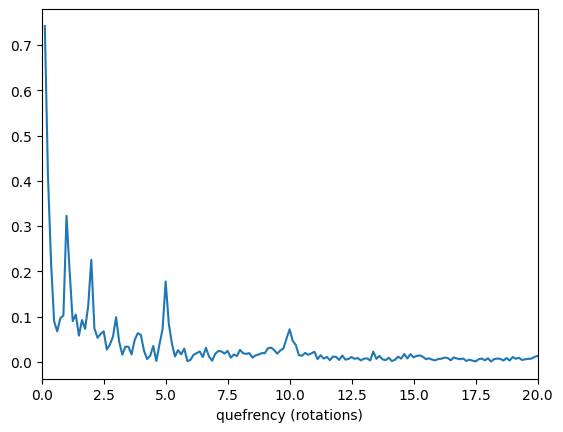

In [ ]:
# --- Cepstrum ---
len_cepstrum = len(P_mean) // 2
p_freq = ifft(np.log(P_mean))[1 : len_cepstrum]
x_freq = np.arange(1, len_cepstrum) / (len(P_mean) / bins_per_interval)

plt.plot(x_freq,np.abs(p_freq))
plt.xlim(0,20)
plt.xlabel("quefrency (rotations)")
# plt.ylim(0,1) 
plt.show()